# 8760 Load Analysis 
## Purpose
The goal of this code is to take 8760 .csv files from electrical system and analyze when and where the load is not being met. It was specifically designed with the output from the HOMER microgrid software in mind. 

In [7]:
# import modules 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os 
import pathlib
from glob  import glob

In [8]:
#define directories 
#load csv file file path 
dir_path = os.path.join(
    pathlib.Path.home(),
        'code-projects',
        'load-8760'
        )

# results directory for saving results
results_dir = os.path.join(dir_path, 'results')
os.makedirs(results_dir, exist_ok=True)

data_files = glob(os.path.join(dir_path,'*.csv'))

In [9]:
# define function for counting consecutive groups, for counting number of outages per day 

def count_consecutive_groups(df):
    groups = (df['hour'].diff() != 1).cumsum()  # Identify consecutive groups
    return len(groups.unique()) 


In [ ]:
# define function for plotting heatmap from days 

def plot_yearly_heatmap(outages_day):
    outages_day['date'] = pd.to_datetime({
    'year': 2000,  # Adjust the year if needed
    'month': outages_day['month'],
    'day': outages_day['day']
})

    # Create a full-year calendar
    full_year = pd.date_range(start='2000-01-01', end='2000-12-31')
    full_year_df = pd.DataFrame({'date': full_year})
    full_year_df['day_of_week'] = full_year_df['date'].dt.dayofweek
    full_year_df['week'] = full_year_df['date'].dt.isocalendar().week

    # Merge outages_day into the full year to align with calendar dates
    full_year_df = full_year_df.merge(
        outages_day[['date', '#_of_outages']],
        on='date',
        how='left'
    )
    full_year_df['#_of_outages'] = full_year_df['#_of_outages'].fillna(0)  # Fill missing values with 0

    # Aggregate data to ensure unique combinations of week and day_of_week
    full_year_df_agg = full_year_df.groupby(['week', 'day_of_week']).agg({'#_of_outages': 'sum'}).reset_index()

    # Pivot the data for heat map structure
    heatmap_data = full_year_df_agg.pivot(index='week', columns='day_of_week', values='#_of_outages')

    #Title Heatmap based on file name
    heatmap_title = 'Daily Outages Heat Map for ' + f"{os.path.basename(data_path)}" 

    # Plot the heat map
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap='cool',  # Color palette
        linewidths=0.5,   # Grid lines
        annot=False,      # Set True if you want annotations
        cbar_kws={'label': 'Number of Outages'}
    )
    plt.title(heatmap_title, fontsize=16)
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Week of the Year', fontsize=12)
    plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the heat map
    output_path = os.path.join(results_dir, f"{os.path.basename(data_path)}_heatmap.png")
    plt.savefig(output_path)
    plt.close()

    return print(f"Saved heat map for {data_path} to {results_dir}")

    

In [11]:
# Number of Customers 

no_customers = 29 

In [12]:


#list to store all results

results = []
outages_summary=[]


for data_path in data_files:
    data = pd.read_csv(
        data_path,
        delimiter=',',
        header= 0,
        index_col='Time',
        skiprows=1)
     
    data= data[data.index.notnull()]

    data=data.reset_index() #Reset Index
    data["Time"] = pd.to_datetime(data["Time"])
    data["hour"] = data['Time'].map(lambda x: x.hour)
    data["day"] = data['Time'].map(lambda x: x.day)
    data["month"] = data['Time'].map(lambda x: x.month)
    

     #Initialize N/A
    hours_shortage = '0'
    hours_battery_shortage = '0'
    hours_unmet_load = '0' 
    num_days_outages = '0' 
    outages_year = '0' 
    # filter  how many hours load not met (capacity shortage > 0)
    if 'Capacity Shortage' in data.columns:
        data['Capacity Shortage'] = data['Capacity Shortage'].astype(float) #first need to force column to convert to float 
        capacity_shortage_df = data[data['Capacity Shortage'] > 0 ]
        hours_shortage = len(capacity_shortage_df)
   

    #Calculate how many hours annual load is unmet   #for Battery <30%
    if 'Generic 1kWh Li-Ion State of Charge' in data.columns:
        data['Generic 1kWh Li-Ion State of Charge'] = data['Generic 1kWh Li-Ion State of Charge'].astype(float)
        battery_shortage_df = data[data['Generic 1kWh Li-Ion State of Charge'] < 30 ]
        hours_battery_shortage = len(battery_shortage_df)

    # To find hours with Unmet Electrical Load
    if 'Unmet Electrical Load' in data.columns:
        data['Unmet Electrical Load'] = data['Unmet Electrical Load'].astype(float)
        unmet_load_df = data[data['Unmet Electrical Load'] > 0.01 ]
        hours_unmet_load = len(unmet_load_df)
    
    hours_per_day = unmet_load_df.groupby(['month','day']).size().reset_index()
    hours_per_day.columns=['month','day','hours_with_unmet_load']
    #Calculate number of days with outages 
    num_days_outages = len(hours_per_day)
    # Calulate number of outages per year
    outages_year = count_consecutive_groups (unmet_load_df)
    #Calculate number of distinct outages 
    outages_day = unmet_load_df.groupby(['month', 'day']).apply(count_consecutive_groups).reset_index()
    outages_day.columns = ['month','day','#_of_outages']

    #calculate annual SAIDI, SAIFI Indecs 
    saidi = hours_unmet_load/no_customers
    saifi = outages_year/no_customers

    #save heatmap for each file
    plot_yearly_heatmap(outages_day)

    #complile a list of results for summary 
    results.append ({
         'File': os.path.basename(data_path),
        'Hours with Capacity Shortage': hours_shortage,
        'Hours with Battery <30%': hours_battery_shortage,
        'Hours with Unmet Load': hours_unmet_load,
        'Days with Outages': num_days_outages,
        'Total Outages (#/year)': outages_year,
        'SAIDI (hrs/year)' : saidi,
        'SAIFI (#/year)' : saifi
    })

    #Merge hours_per_day and outages_day data frames
    if not hours_per_day.empty and not outages_day.empty:
        merged = pd.merge(hours_per_day, outages_day, on=['month', 'day'], how='outer')
        merged['File'] = os.path.basename(data_path)
        outages_summary.append(merged)

results_df = pd.DataFrame(results)
outages_summary_df = pd.concat(outages_summary, ignore_index=True)



C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Time"] = pd.to_datetime(data["Time"])
C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outages_day = unmet_load_df.groupby(['month', 'day']).apply(count_consecutive_groups).reset_index()


Saved heat map for C:\Users\Nolan Welsh\code-projects\load-8760\Results_Base_#1.csv to C:\Users\Nolan Welsh\code-projects\load-8760\results


C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Time"] = pd.to_datetime(data["Time"])
C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outages_day = unmet_load_df.groupby(['month', 'day']).apply(count_consecutive_groups).reset_index()


Saved heat map for C:\Users\Nolan Welsh\code-projects\load-8760\Results_Base_#10.csv to C:\Users\Nolan Welsh\code-projects\load-8760\results


C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Time"] = pd.to_datetime(data["Time"])
C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outages_day = unmet_load_df.groupby(['month', 'day']).apply(count_consecutive_groups).reset_index()


Saved heat map for C:\Users\Nolan Welsh\code-projects\load-8760\Results_Base_#11.csv to C:\Users\Nolan Welsh\code-projects\load-8760\results


C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Time"] = pd.to_datetime(data["Time"])
C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outages_day = unmet_load_df.groupby(['month', 'day']).apply(count_consecutive_groups).reset_index()


Saved heat map for C:\Users\Nolan Welsh\code-projects\load-8760\Results_Base_#12.csv to C:\Users\Nolan Welsh\code-projects\load-8760\results


C:\Users\Nolan Welsh\AppData\Local\Temp\ipykernel_7488\855086609.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Time"] = pd.to_datetime(data["Time"])


KeyboardInterrupt: 

In [ ]:
results_df


,File,Hours with Capacity Shortage,Hours with Battery <30%,Hours with Unmet Load,Days with Outages,Total Outages (#/year),SAIDI (hrs/year),SAIFI (#/year)
0,Results_Base_#1.csv,1702,1967,1292,165,233,44.551724,8.034483
1,Results_Base_#10.csv,975,1011,676,93,123,23.310345,4.241379
2,Results_Base_#11.csv,1588,1788,1179,145,195,40.655172,6.724138
3,Results_Base_#12.csv,802,993,605,89,103,20.862069,3.551724
4,Results_Base_#13.csv,NA,47,10,3,4,0.344828,0.137931
...,...,...,...,...,...,...,...,...
67,Results_P3_#5.csv,992,1115,698,107,144,24.068966,4.965517
68,Results_P3_#6.csv,880,1040,663,91,119,22.862069,4.103448
69,Results_P3_#8.csv,1783,1814,1207,163,249,41.620690,8.586207
70,Results_P3_#9.csv,914,1000,649,92,127,22.379310,4.379310


In [ ]:
outages_summary_df

,month,day,hours_with_unmet_load,#_of_outages,File
0,1,2,1,1,Results_Base_#1.csv
1,1,4,3,1,Results_Base_#1.csv
2,1,8,8,1,Results_Base_#1.csv
3,1,12,4,1,Results_Base_#1.csv
4,1,13,10,1,Results_Base_#1.csv
...,...,...,...,...,...
6390,12,23,1,1,Results_P7_#2.csv
6391,12,24,2,1,Results_P7_#2.csv
6392,12,25,2,1,Results_P7_#2.csv
6393,12,30,2,1,Results_P7_#2.csv


In [ ]:
outages_day

,month,day,#_of_outages
0,1,1,2
1,1,2,1
2,1,8,1
3,1,11,1
4,1,12,4
...,...,...,...
183,12,23,1
184,12,24,1
185,12,25,1
186,12,30,1


Save Summary  results 

In [ ]:

summary_path = os.path.join(results_dir, 'outages_summary_results.csv')
results_df.to_csv(summary_path, index=False)

outages_daily_detail_path = os.path.join(results_dir,'outages_daily_details.csv')
outages_summary_df.to_csv(outages_daily_detail_path, index=False)



### Try to Plot a Heat Map of Outages Per a Day


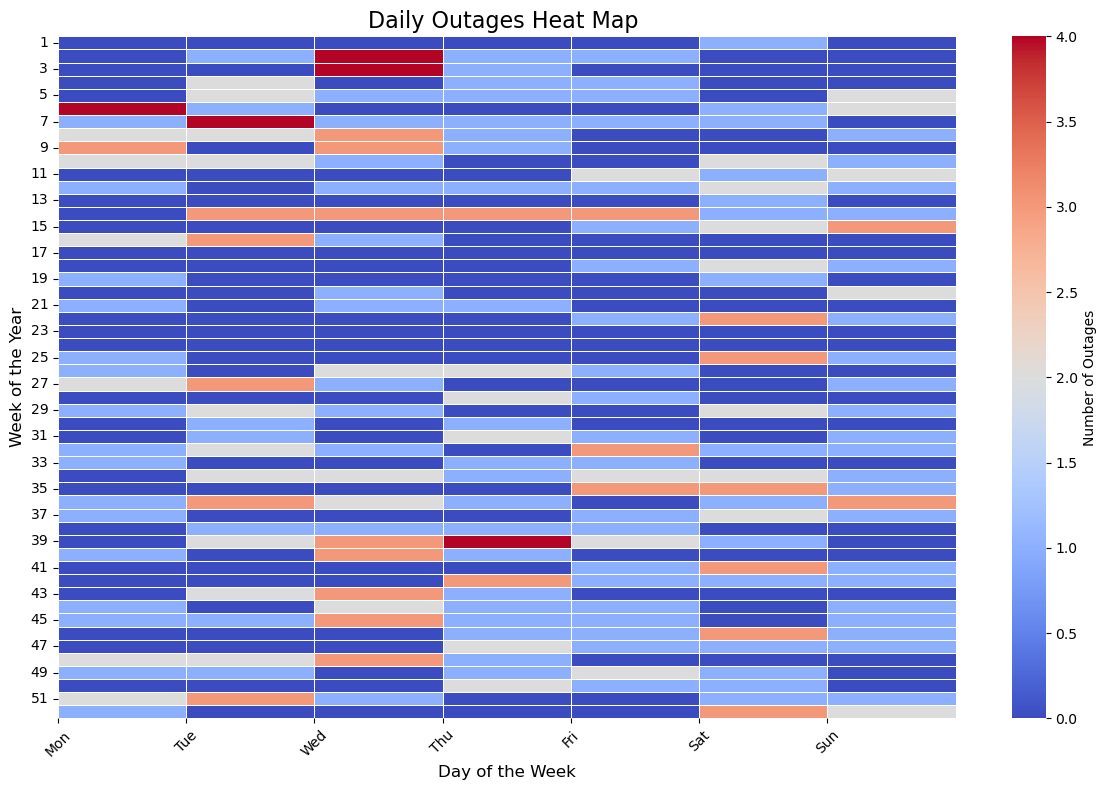

In [ ]:
outages_day['date'] = pd.to_datetime({
    'year': 2000,  # Adjust the year if needed
    'month': outages_day['month'],
    'day': outages_day['day']
})

# Create a full-year calendar
full_year = pd.date_range(start='2000-01-01', end='2000-12-31')
full_year_df = pd.DataFrame({'date': full_year})
full_year_df['day_of_week'] = full_year_df['date'].dt.dayofweek
full_year_df['week'] = full_year_df['date'].dt.isocalendar().week

# Merge outages_day into the full year to align with calendar dates
full_year_df = full_year_df.merge(
    outages_day[['date', '#_of_outages']],
    on='date',
    how='left'
)
full_year_df['#_of_outages'] = full_year_df['#_of_outages'].fillna(0)  # Fill missing values with 0

# Aggregate data to ensure unique combinations of week and day_of_week
full_year_df_agg = full_year_df.groupby(['week', 'day_of_week']).agg({'#_of_outages': 'sum'}).reset_index()

# Pivot the data for heat map structure
heatmap_data = full_year_df_agg.pivot(index='week', columns='day_of_week', values='#_of_outages')

# Plot the heat map
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',  # Color palette
    linewidths=0.5,   # Grid lines
    annot=False,      # Set True if you want annotations
    cbar_kws={'label': 'Number of Outages'}
)
plt.title('Daily Outages Heat Map ', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Week of the Year', fontsize=12)
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
full_year_df

,date,day_of_week,week,#_of_outages
0,2000-01-01,5,52,2.0
1,2000-01-02,6,52,1.0
2,2000-01-03,0,1,0.0
3,2000-01-04,1,1,0.0
4,2000-01-05,2,1,0.0
...,...,...,...,...
361,2000-12-27,2,52,0.0
362,2000-12-28,3,52,0.0
363,2000-12-29,4,52,0.0
364,2000-12-30,5,52,1.0
